In [7]:
####Rene 7_30_2021 update 4/1/2022

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Settings for pattern mining
timerange=(7,11) #in minutes
peakwidth=0.25 #in minutes
slope_filter=(0.5,2) # normalized slope (1=true)
correlation=0.8 #minimum r-squared correlation cut-off. 

mass_tolerance=0.001
ratio_tolerance=1.5

###### Set file folder and THERMO RAW file name here:
file_location = '/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS_Metallomics_Data/'
file_name="rmb_161221_kansas_h2o_2"

#####Set isotope pattern

#isotopes=['54Fe','56Fe','57Fe']
#requirement=['Y','Y','N']

isotopes=['63Cu','65Cu']
requirement=['Y','Y']

#isotopes=['64Zn','66Zn','68Zn']
#requirement=['Y','Y','Y']

#isotopes=['12C','13C']
#requirement=['Y','Y']

# Import the os module
import os
import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters


#Set peak detection threshold method

MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 3

MSParameters.ms_peak.peak_min_prominence_percent = 0.001

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+file_name)


In [8]:
#Create isotope pattern
from support_code import AtomsDescription_standardized as atom
pattern=atom.ipattern(isotopes,requirement,atom.atoms)

print(pattern)

  isotope       mass  abundance element requirement     mdiff     ratio
0    63Cu  62.929598   0.691515      Cu           Y  0.000000  1.000000
1    65Cu  64.927790   0.308515      Cu           Y  1.998192  0.446144


In [9]:
#Isotope pattern search function.

#Define the isotopic pattern boundaries based on 'pattern'. Results is a dictionary w/ key 'scan #s' containing a list of dictionaries w/ isotope patterns. 
def isotopehunter(lcms,pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter):
    #Function matches required ('Y') peaks in pattern to spectra in lcms
    #Requires 'timerange','mass_tolerance','ratio_tolerance' for pattern matching
    #Requires 'pattern','peakwidth','correlation','slope_filter' for QC filtering

    #Define pattern boundaries
    umass=pattern.mdiff[pattern.requirement=='Y']+mass_tolerance
    lmass=pattern.mdiff[pattern.requirement=='Y']-mass_tolerance
    uratio=pattern.ratio[pattern.requirement=='Y']*ratio_tolerance
    lratio=pattern.ratio[pattern.requirement=='Y']/ratio_tolerance
    nisotope=len(umass)

    #Retrieve TIC for MS1 scans only within timerange
    tic=lcms.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})
    scans=tic_df[tic_df.time.between(timerange[0],timerange[1])].scan.tolist()

    #Create  empty results dictionaries. Will be filed with {Scan: {1st peak:{mz,intense}, 2nd peak:{mz,intense}, npeak:{mz,intense}}}
    results=[]
    clean_results=[]
    final_results=[]

    #Determine 2 most abundant isotopologues for correlation analysis.  
    req_isotopes=pattern[pattern.requirement=='Y'].isotope
    isotope1=req_isotopes[0]
    isotope2=req_isotopes[1]

    #Currently, this is a simple script that matches every peak in a spectra. In future, can speed up by looking at data subsets. 
        #mzint=20
        #mzbuffer=uppermass.iloc[-1]

    for s in scans:
        ms=lcms.get_average_mass_spectrum_by_scanlist([s])
        spectrum=pd.DataFrame({'mz':ms.mz_exp, 'intense':ms.abundance})
        #print(s)
        if(spectrum.shape[0]>2):
                    
            for j in spectrum.index:
                k=1
                hitlist=[]
                result={}

                while(k<nisotope):
                    hits=spectrum[(spectrum.mz > spectrum.mz[j]+lmass[k]) & (spectrum.mz < spectrum.mz[j]+umass[k]) & (spectrum.intense > spectrum.intense[j]*lratio[k]) & (spectrum.intense < spectrum.intense[j]*uratio[k])].index.tolist()
                    if hits:
                        hitlist.append(hits)
                        k=k+1
                    else:
                        k=nisotope+1
                if k==(nisotope):
                    result['scan']=s
                    result['time']=tic_df[tic_df.scan==s].time.iloc[0]

                    result[pattern.isotope[0]]={'mz':spectrum.mz[j],'intense':spectrum.intense[j]}

                    for i, iso in enumerate(req_isotopes[1:]):
                        #result[pattern.isotope[i]]={'mz':spectrum.mz[hitlist[i-1][0]],'intense':spectrum.intense[hitlist[i-1][0]]}
                        result[iso]={'mz':spectrum.mz[hitlist[i][0]],'intense':spectrum.intense[hitlist[i][0]]}
                    mass1=result[isotope1]['mz']
                    mass2=result[isotope2]['mz']

                    tstart=result['time']-peakwidth
                    tstop=result['time']+peakwidth

                    EIC=parser.get_eics(target_mzs=[mass1,mass2],tic_data={},peak_detection=False,smooth=False)
                    df=pd.DataFrame({'mz1':EIC[0][mass1].eic,'mz2':EIC[0][mass2].eic,'time':EIC[0][mass1].time})
                    df_sub=df[df['time'].between(tstart,tstop)]

                    #Calculate correlation and slope between two main isotopologues.        
                    corr=df_sub.corr(method='pearson').iat[0,1]**2
                    slope=np.polyfit(df_sub.mz1,df_sub.mz2,1)[0]/(pattern.sort_values(by='ratio',ascending=False).ratio[1]/pattern.sort_values(by='ratio',ascending=False).ratio[0])
                    result['corr']=corr
                    result['slope']=slope
                    result['mass']=round(mass1,3)
                    result['abundance']=result[isotope1]['intense']
                    result['qc']='match'

                    if corr>correlation:
                        if ((slope > slope_filter[0]) & (slope < slope_filter[1])):
                            clean_results.append(result)
                            result['qc']='qc'

                    results.append(result)

    clean_results_df=pd.DataFrame(clean_results)

    for result in clean_results:
        masses=clean_results_df[(abs(clean_results_df.mass-result['mass']) < mass_tolerance)& (abs(clean_results_df.time - result['time']) < peakwidth*2)]
        max_value=max(masses.abundance)

        if (result['abundance']==max_value):
            final_results.append(result)
            result['qc']='max'

    return(results,clean_results,final_results)   
    
results=isotopehunter(parser,pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter)



In [10]:
print(pd.DataFrame(results[0]))

    scan       time                                               63Cu  \
0   2070   7.018282  {'mz': 346.90819830279435, 'intense': 8902.288...   
1   2082   7.068878  {'mz': 216.95057571635624, 'intense': 24407.58...   
2   2094   7.110575  {'mz': 328.89781166533203, 'intense': 10163.16...   
3   2094   7.110575  {'mz': 346.90826435022524, 'intense': 9168.463...   
4   2118   7.193496  {'mz': 346.90819254962855, 'intense': 7659.809...   
5   2130   7.237285  {'mz': 346.908202449942, 'intense': 9317.30371...   
6   2298   7.810892  {'mz': 430.8880261917303, 'intense': 7843.4775...   
7   2358   8.017658  {'mz': 291.0386251740062, 'intense': 9880.9951...   
8   2370   8.060795  {'mz': 430.8878957513614, 'intense': 9217.6552...   
9   2418   8.252104  {'mz': 328.89770070682516, 'intense': 3547.463...   
10  2430   8.292718  {'mz': 212.12807288287206, 'intense': 2202.507...   
11  2430   8.292718  {'mz': 234.1342647930173, 'intense': 1996.8382...   
12  2455   8.375203  {'mz': 328.897657

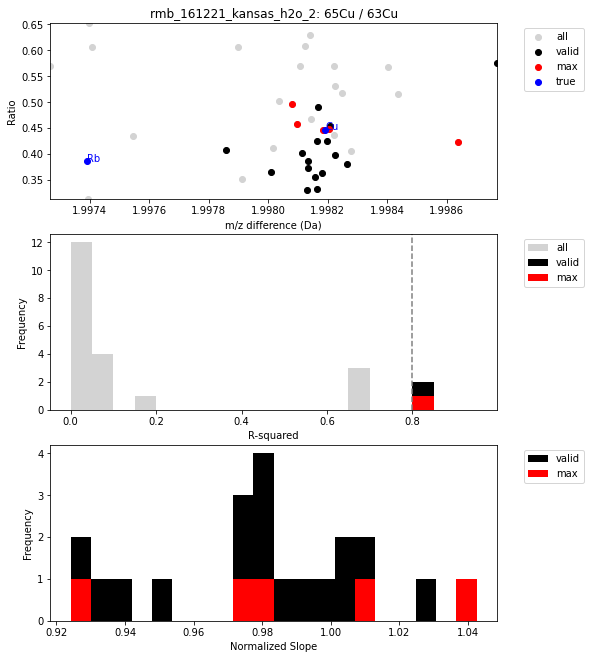

In [11]:
#Plot QC figures:

#First, plot mass error vs. ratio

def isotopehunter_qc_plots(results,file_name):
    mzdif=[]
    r_dif=[]
    qc=[]

    elementpatterns=pd.DataFrame(atom.get_elementpattern())

    #Determine 2 most abundant isotopologues for correlation analysis.  
    isotope1=pattern.sort_values(by='ratio',ascending=False).isotope[0]
    isotope2=pattern.sort_values(by='ratio',ascending=False).isotope[1]

    for result in results[0]:
        mzdif.append(result[isotope2]['mz']-result[isotope1]['mz'])
        r_dif.append(result[isotope2]['intense']/result[isotope1]['intense'])
        qc.append(result['qc'])
        result['dmz']=result[isotope2]['mz']-result[isotope1]['mz']

    plot_df=pd.DataFrame({'mzdif':mzdif,'rdif':r_dif,'qc':qc})
    clean_results=results[1]
    final_results=results[2]

    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    fig.set_size_inches(8,11)

    allcolor='lightgray'
    validcolor='black'
    maxcolor='red'
    ax1.scatter('mzdif','rdif',color=allcolor,data=plot_df)
    ax1.scatter('mzdif','rdif',color=validcolor,data=plot_df[plot_df.qc=='qc'])
    ax1.scatter('mzdif','rdif',color=maxcolor,data=plot_df[plot_df.qc=='max'])
    ax1.scatter('mdiff','ratio',color='blue',data=elementpatterns)
    for i, txt in enumerate(elementpatterns.element):
        ax1.annotate(txt, (elementpatterns.mdiff.iloc[i], elementpatterns.ratio.iloc[i]),color='blue')
    #ax1.scatter('mdiff','ratio',color='blue',data=pattern[pattern.isotope==isotope2])
    ax1.set(xlabel='m/z difference (Da)',ylabel='Ratio',title=file_name + ': '+ isotope2 + ' / ' + isotope1)
    ax1.set(xlim=[min(mzdif),max(mzdif)], ylim=[min(r_dif),max(r_dif)])
    ax1.legend(['all','valid','max','true'],bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(results[0]),color=allcolor)
    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(clean_results),color=validcolor)
    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(final_results),color=maxcolor)
    ax2.legend(['all','valid','max'],bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax2.set(xlabel='R-squared',ylabel='Frequency')
    ax2.axvline(x=correlation, color='gray', linestyle='dashed')

    ax3.hist('slope',bins=20,data=pd.DataFrame(clean_results),color=validcolor)
    ax3.hist('slope',bins=20,data=pd.DataFrame(final_results),color=maxcolor)
    ax3.set(xlabel='Normalized Slope',ylabel='Frequency')
    ax3.legend(['valid','max'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax2.axvline(x=correlation)
    return(fig)

isotopehunter_qc_plots(results,file_name)
plt.show()


'runworker'  10.71 ms


Loading molecular formula database: 143278it [00:08, 17713.22it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 275.86it/s]


'run_molecular_formula'  8924.99 ms
'runworker'  10.99 ms


Loading molecular formula database: 143278it [00:07, 18008.14it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 248.76it/s]


'run_molecular_formula'  8868.37 ms
'runworker'  15.75 ms


Loading molecular formula database: 143278it [00:07, 19402.19it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 218.39it/s]


'run_molecular_formula'  8419.45 ms
'runworker'  15.61 ms


Loading molecular formula database: 143278it [00:08, 16178.16it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 242.34it/s]


'run_molecular_formula'  9806.07 ms
'runworker'  11.25 ms


Loading molecular formula database: 143278it [00:07, 19386.18it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 282.17it/s]


'run_molecular_formula'  8186.36 ms


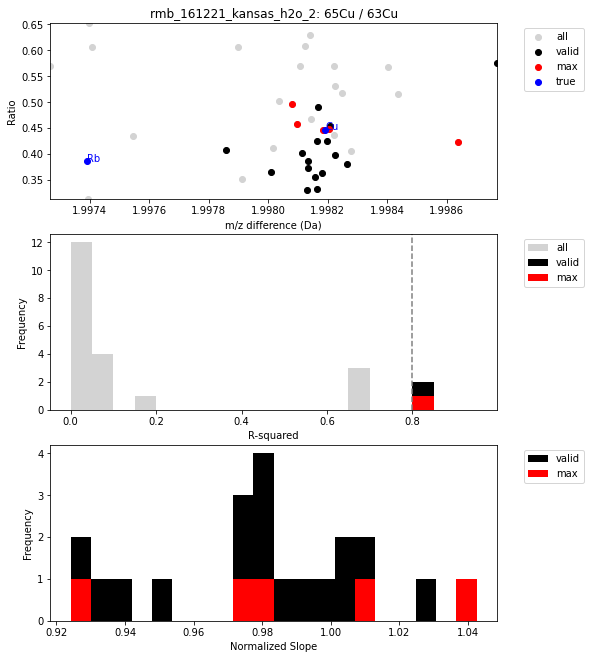

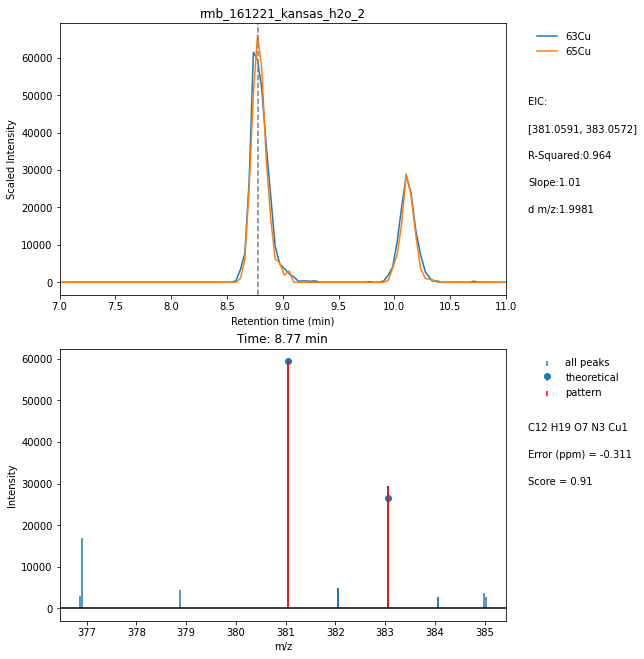

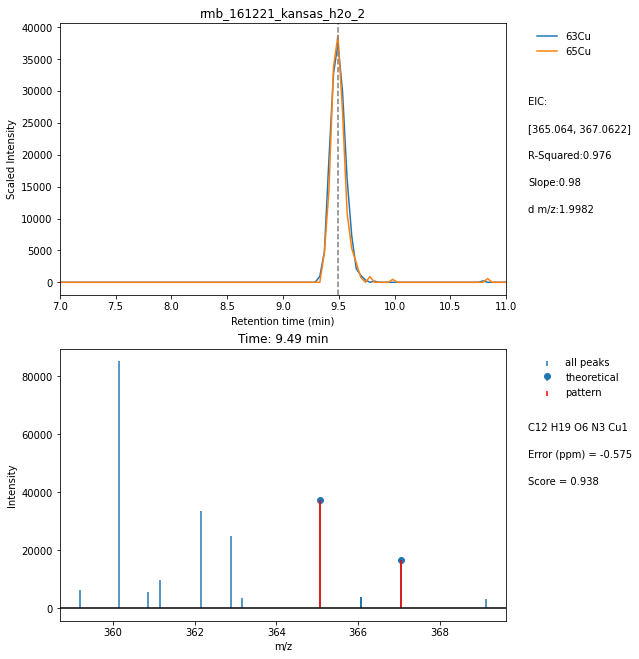

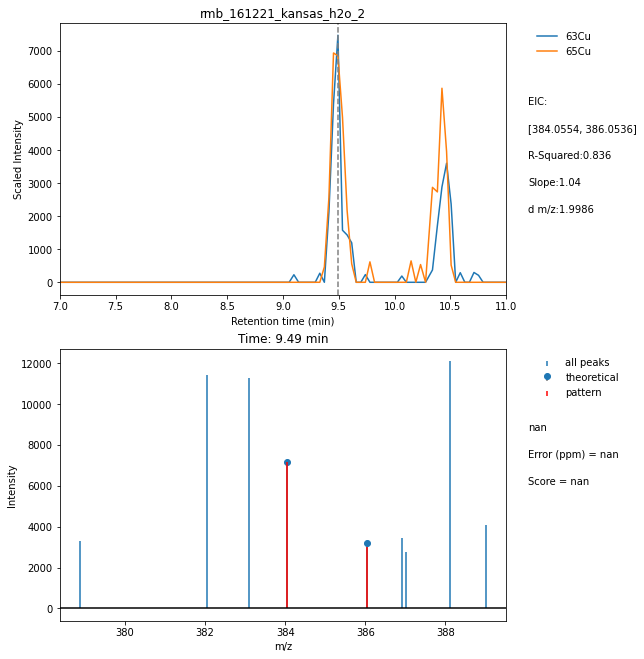

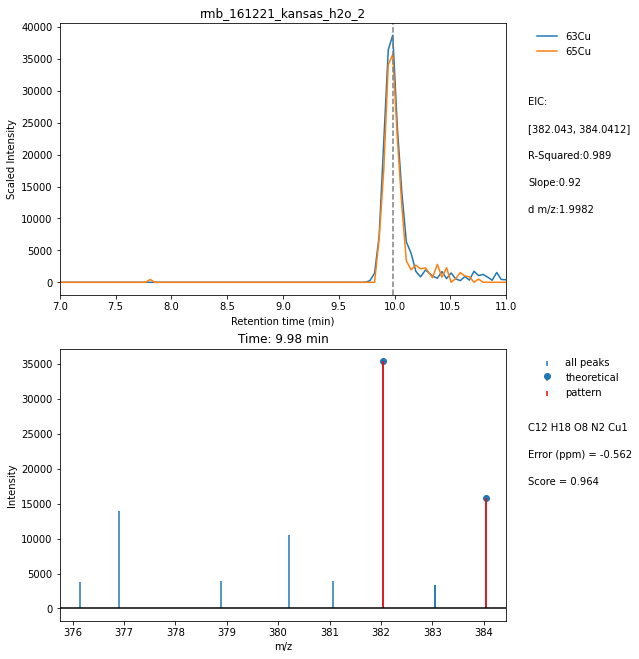

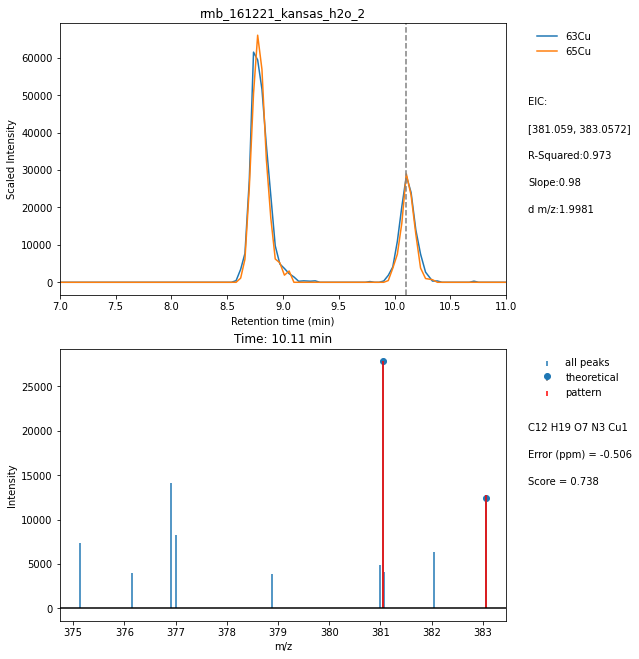

In [12]:
def isotope_result_plotter(result,lcms,pattern,file_name):
    
    #Determine 2 most abundant isotopologues for correlation analysis.  
    isotope1=pattern.sort_values(by='ratio',ascending=False).isotope[0]
    isotope2=pattern.sort_values(by='ratio',ascending=False).isotope[1]
    

    plotmasses=pattern.mdiff+result[isotope1]['mz']-pattern[pattern.isotope==isotope1].mdiff.iloc[0]

    eics=lcms.get_eics(target_mzs=plotmasses.to_list(),tic_data={},peak_detection=False,smooth=False)

    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(8,11)

    for i in plotmasses.index:
        ax1.plot(eics[0][plotmasses[i]].time, eics[0][plotmasses[i]].eic/pattern.ratio[i])
    ax1.set(xlabel='Retention time (min)',ylabel='Scaled Intensity',xlim=timerange)
    ax1.set_title(file_name)
    ax1.legend(pattern.isotope.to_list(),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
    ax1.text(1.05,0.7,'EIC:',transform=ax1.transAxes)
    ax1.text(1.05,0.6,plotmasses.round(4).to_list(),transform=ax1.transAxes)
    ax1.text(1.05,0.5,'R-Squared:'+ result['corr'].round(3).astype(str),transform=ax1.transAxes)
    ax1.text(1.05,0.4,'Slope:'+ result['slope'].round(2).astype(str),transform=ax1.transAxes)
    ax1.text(1.05,0.3,'d m/z:'+ result['dmz'].round(4).astype(str),transform=ax1.transAxes)
    ax1.axvline(x=result['time'],color='gray',linestyle='dashed')

    #What is faster way to get a scan?
    mass_spectrum=lcms.get_average_mass_spectrum_by_scanlist([result['scan']])

    #Get molecular formula of average mass spectrum. 

    mass_spectrum.molecular_search_settings.error_method = 'None'
    mass_spectrum.molecular_search_settings.min_ppm_error = -2
    mass_spectrum.molecular_search_settings.max_ppm_error = 2

    mass_spectrum.molecular_search_settings.url_database = None
    mass_spectrum.molecular_search_settings.min_dbe = 0
    mass_spectrum.molecular_search_settings.max_dbe = 16

    mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 50)
    mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 100)
    mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 20)
    mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 4)
    mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Cl'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Br'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['P'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Na'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Fe'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Cu'] = (0, 1)
    mass_spectrum.molecular_search_settings.usedAtoms['Zn'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Ni'] = (0, 0)

    #for element in pattern.element:
    #    print(element)
    #    mass_spectrum.molecular_search_settings.usedAtoms[element] = (0,1)

    mass_spectrum.molecular_search_settings.isProtonated = True
    mass_spectrum.molecular_search_settings.isRadical = False
    mass_spectrum.molecular_search_settings.isAdduct = False


    # mass_spectrum.filter_by_max_resolving_power(15, 2)
    SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

    ms_df=mass_spectrum.to_dataframe()

    ms_df_range=ms_df[(abs(ms_df['m/z']-result['mass'])<6)]
    mf=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['Molecular Formula'].iloc[0]
    error=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['m/z Error (ppm)'].iloc[0]
    score=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['Confidence Score'].iloc[0]

    result['Molecular Formula']=mf
    result['Error']=error
    result['Score']=score

    ax2.stem('m/z','Peak Height',data=ms_df_range,  markerfmt=' ', basefmt=' ')
    
    theor_mz=pattern.mdiff+result['mass']
    theor_int=pattern.ratio*result['abundance']
    ax2.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

    for isotope in pattern.isotope[pattern.requirement=='Y']:
        ax2.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')


    ax2.legend(('all peaks','theoretical','pattern'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
    ax2.set(xlabel='m/z',ylabel='Intensity')
    ax2.set_title('Time: '+result['time'].round(2).astype(str)+' min')
    ax2.text(1.05,0.7,mf,transform=ax2.transAxes)
    ax2.text(1.05,0.6,'Error (ppm) = '+round(error,3).astype(str),transform=ax2.transAxes)
    ax2.text(1.05,0.5,'Score = '+round(score,3).astype(str),transform=ax2.transAxes)
    ax2.axhline(y=0.0, color='black')

    return(fig)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(file_location+file_name+'_63Cu.pdf')

pdf.savefig(isotopehunter_qc_plots(results,file_name),dpi=200,bbox_inches='tight')

for result in results[2]:
    pdf_fig=isotope_result_plotter(result,parser,pattern,file_name)
    pdf.savefig(pdf_fig,dpi=200,bbox_inches='tight')

pdf.close()
plt.show()